In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


# Dataset

In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
batch_size=100

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

train_loader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

val_loader = DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Training code

In [5]:
def train_model(model_name, model, criterion, optimizer, scheduler, epochs=5, patience=5, device='cpu', inputs_requires_grad=False):
    model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': [],
        'epoch_time': []
    }
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs.requires_grad = inputs_requires_grad
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100.0 * train_correct / train_total

        # validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
                
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100.0 * val_correct / val_total

        scheduler.step(epoch_val_loss)

        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['lr'].append(current_lr)
        
        # print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print(f"Learning Rate: {current_lr:.6f}")
        print("-" * 60)

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            torch.save(model.state_dict(), f'best_{model_name}_model.pth')
        else:
            counter += 1
            print(f'No improvement for {counter} epochs.')
            
            if counter >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(torch.load(f'best_{model_name}_model.pth'))
    
    return model, history

# Inference function

In [6]:
def inference(model, image, device='cpu'):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    model.to(device)
    model.eval()

    if isinstance(image, str):
        image = Image.open(image).convert('RGB')

    if not isinstance(image, torch.Tensor):
        transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
        ])

        image = transform(image)

    
    if image.dim() == 3:
        image = image.unsqueeze(0)

    with torch.no_grad():
        image = image.to(device)
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    predicted_idx = predicted.item()
    predicted_class = classes[predicted_idx]
    
    return predicted_class, predicted.item(), probabilities[0]

# AlexNet

In [100]:
alex_net = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=2, stride=1, padding=1),
    nn.BatchNorm2d(96),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(256, 384, kernel_size=3, padding=1), 
    nn.BatchNorm2d(384),
    nn.ReLU(),
    
    nn.Conv2d(384, 384, kernel_size=3, padding=1), 
    nn.BatchNorm2d(384),
    nn.ReLU(),
    
    nn.Conv2d(384, 256, kernel_size=3, padding=1), 
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),

    nn.Linear(4096, 1024), nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(1024, 512), nn.ReLU(),
    nn.Dropout(p=0.6),

    nn.Linear(512, 10)
)

alex_net

Sequential(
  (0): Conv2d(3, 96, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momen

In [101]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alex_net.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

alex_net_best_model, history = train_model("alex_net", alex_net, criterion, optimizer, scheduler, epochs=30, patience=5, device='cuda')

Epoch 1/30
Train Loss: 1.9671, Train Acc: 26.76%
Val Loss: 1.5806, Val Acc: 42.29%
Learning Rate: 0.000010
------------------------------------------------------------
Epoch 2/30
Train Loss: 1.5971, Train Acc: 40.38%
Val Loss: 1.3080, Val Acc: 52.79%
Learning Rate: 0.000010
------------------------------------------------------------
Epoch 3/30
Train Loss: 1.4018, Train Acc: 48.53%
Val Loss: 1.2026, Val Acc: 56.83%
Learning Rate: 0.000010
------------------------------------------------------------
Epoch 4/30
Train Loss: 1.2734, Train Acc: 53.74%
Val Loss: 1.1255, Val Acc: 59.62%
Learning Rate: 0.000010
------------------------------------------------------------
Epoch 5/30
Train Loss: 1.1764, Train Acc: 57.62%
Val Loss: 1.0395, Val Acc: 62.85%
Learning Rate: 0.000010
------------------------------------------------------------
Epoch 6/30
Train Loss: 1.1041, Train Acc: 60.79%
Val Loss: 0.9578, Val Acc: 65.42%
Learning Rate: 0.000010
-----------------------------------------------------

C:\Users\joao_\AppData\Local\Temp\ipykernel_27584\1900169110.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{model_name}_model.

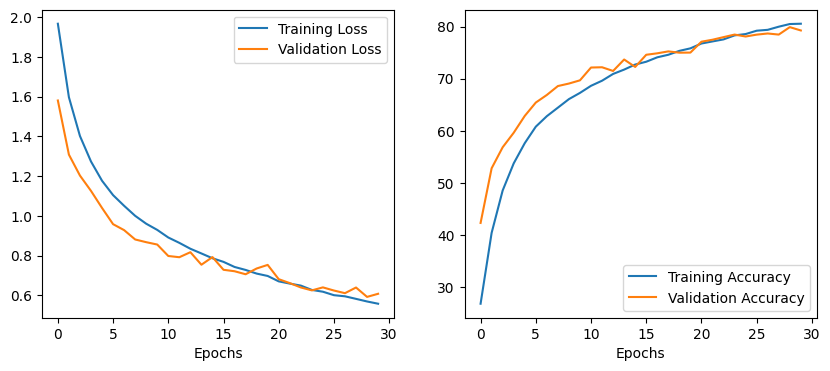

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

axs[0].plot(history["train_loss"], label='Training Loss')
axs[0].plot(history["val_loss"], label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot(history["train_acc"], label='Training Accuracy')
axs[1].plot(history["val_acc"], label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].legend()

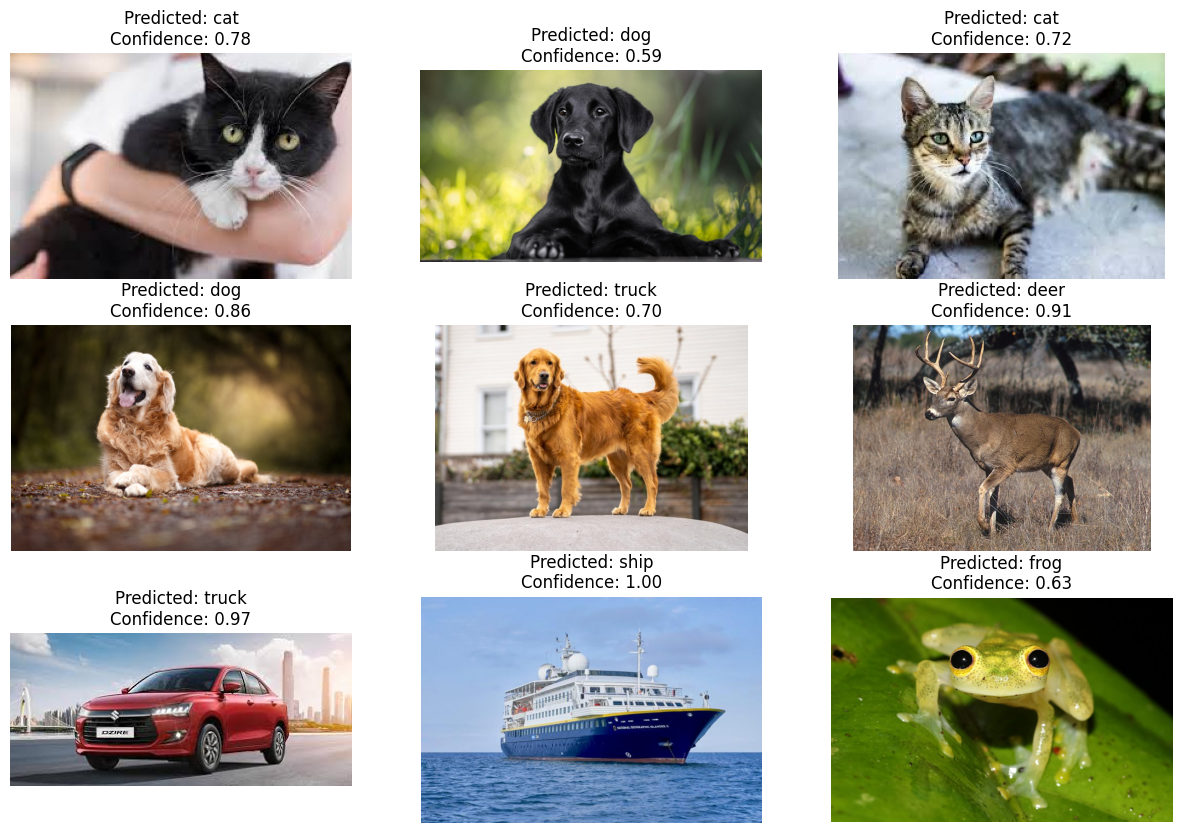

In [146]:
imgs = [
    r"C:\Users\joao_\Downloads\images (1).jpg",
    r"C:\Users\joao_\Downloads\88ff5600-d979-11ef-a5c8-1da73bd59591.jpg",
    r"C:\Users\joao_\Downloads\images.jpg",
    r"C:\Users\joao_\Downloads\iStock-1052880600.jpg",
    r"C:\Users\joao_\Downloads\Golden+Retrievers+dans+pet+care.jpeg",
    r"C:\Users\joao_\Downloads\640px-White-tailed_deer.jpg",
    r"C:\Users\joao_\Downloads\images (2).jpg",
    r"C:\Users\joao_\Downloads\new-day-2-islander-ii-jan23-1000x666.jpg.adapt.six-sixty-seven.jpg",
    r"C:\Users\joao_\Downloads\Glass_Frog.jpg"
]

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()

for idx, img_path in enumerate(imgs):
    img = Image.open(img_path)
    axs[idx].imshow(img)
    axs[idx].axis('off')
    
    pred_class_str, pred_class_n, probs = inference(alex_net_best_model, img)
    axs[idx].set_title(f'Predicted: {pred_class_str}\nConfidence: {probs[pred_class_n]:.2f}')

# ResNet

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()

        # if stride != 1 or input channels != output channels, we need to use a projection shortcut
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu(x)

        x = self.conv_2(x)
        x = self.bn_2(x)

        x += self.shortcut(residual)
        x = self.relu(x)

        return x

In [8]:
class ResNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # initial conv layer
        self.conv_1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn_1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer_1 = self._make_layer(64, 3, stride=1)
        self.layer_2 = self._make_layer(128, 4, stride=2)
        self.layer_3 = self._make_layer(256, 6, stride=2)
        self.layer_4 = self._make_layer(512, 3, stride=2)

        # pooling and out
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
        
        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
            
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [ ]:
resnet = ResNet(10)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

resnet_best_model, history = train_model("resnet", resnet, criterion, optimizer, scheduler, epochs=80, patience=5, device='cuda')

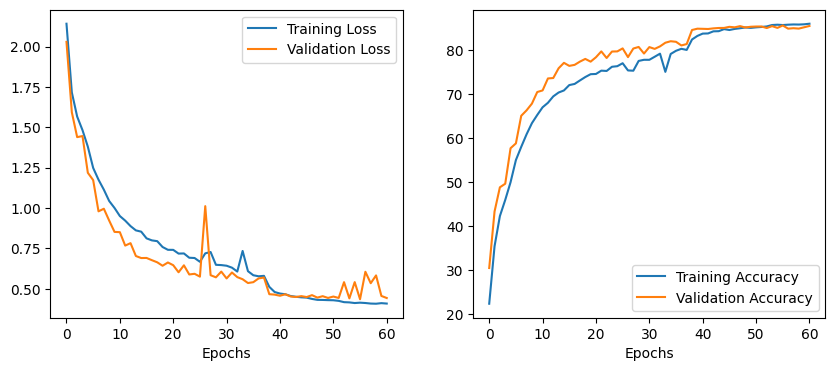

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

axs[0].plot(history["train_loss"], label='Training Loss')
axs[0].plot(history["val_loss"], label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot(history["train_acc"], label='Training Accuracy')
axs[1].plot(history["val_acc"], label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].legend()

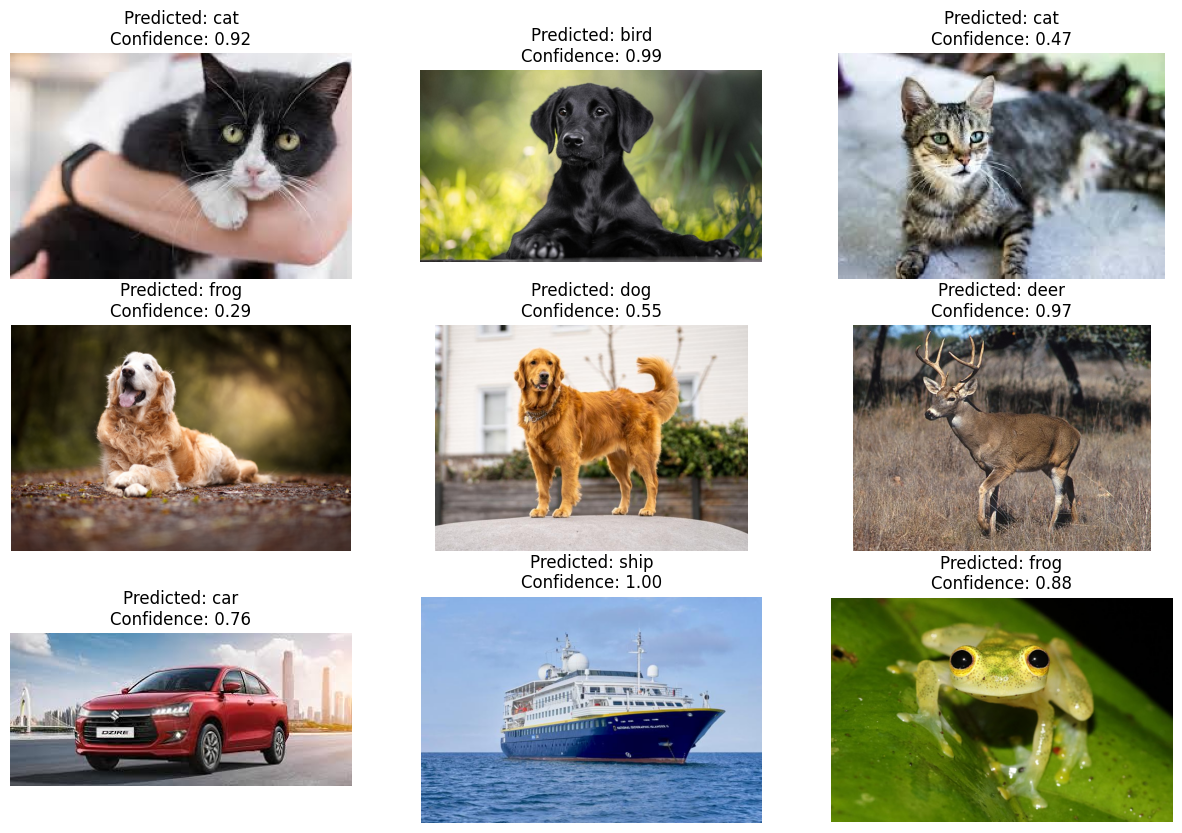

In [18]:
imgs = [
    r"C:\Users\joao_\Downloads\images (1).jpg",
    r"C:\Users\joao_\Downloads\88ff5600-d979-11ef-a5c8-1da73bd59591.jpg",
    r"C:\Users\joao_\Downloads\images.jpg",
    r"C:\Users\joao_\Downloads\iStock-1052880600.jpg",
    r"C:\Users\joao_\Downloads\Golden+Retrievers+dans+pet+care.jpeg",
    r"C:\Users\joao_\Downloads\640px-White-tailed_deer.jpg",
    r"C:\Users\joao_\Downloads\images (2).jpg",
    r"C:\Users\joao_\Downloads\new-day-2-islander-ii-jan23-1000x666.jpg.adapt.six-sixty-seven.jpg",
    r"C:\Users\joao_\Downloads\Glass_Frog.jpg"
]

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()

for idx, img_path in enumerate(imgs):
    img = Image.open(img_path)
    axs[idx].imshow(img)
    axs[idx].axis('off')
    
    pred_class_str, pred_class_n, probs = inference(resnet_best_model, img)
    axs[idx].set_title(f'Predicted: {pred_class_str}\nConfidence: {probs[pred_class_n]:.2f}')

# DenseNet

In [7]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels,  growth_rate, bn_size, drop_rate):
        super(DenseLayer, self).__init__()

        # bottleneck layer
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

         # main convolution
        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.drop_rate = drop_rate

    def forward(self, x):
        prev_features = x
        out = self.conv1(self.relu1(self.norm1(x)))
        out = self.conv2(self.relu2(self.norm2(out)))
        
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
            
        out = torch.cat([prev_features, out], 1)
        
        return out

In [8]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate, bn_size, drop_rate):
        super(DenseBlock, self).__init__()

        layers = []
        for i in range(num_layers):
            layer = DenseLayer(
                in_channels + i * growth_rate,
                growth_rate,
                bn_size,
                drop_rate
            )
            layers.append(layer)
            
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [9]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        
        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.norm(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.pool(x)

        return x

In [10]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), 
                 num_init_features=64, bn_size=4, drop_rate=0, 
                 num_classes=1000, compression=0.5):
        super(DenseNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        )

        num_features = num_init_features

        for i, num_layers in enumerate(block_config):
            block = DenseBlock(
                num_layers=num_layers,
                in_channels=num_features,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.features.add_module(f'denseblock{i+1}', block)

            num_features = num_features + num_layers * growth_rate

            if i != len(block_config) - 1:
                out_features = int(num_features * compression)
                
                trans = TransitionLayer(
                    in_channels=num_features,
                    out_channels=out_features
                )
                self.features.add_module(f'transition{i+1}', trans)
                
                num_features = out_features

        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.features.add_module('relu5', nn.ReLU(inplace=True))
        self.classifier = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)

        x = F.adaptive_avg_pool2d(features, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

In [11]:
dense_net = DenseNet(growth_rate=32, num_init_features=32, block_config=[6,12,32,32], drop_rate=0.2, num_classes=10)
dense_net

DenseNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (block): Sequential(
        (0): DenseLayer(
          (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [12]:
criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(dense_net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.Adam(dense_net.parameters(), lr=0.01)

optimizer = torch.optim.SGD(
    dense_net.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=1e-4,
    nesterov=True
)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=200,
    eta_min=0
)

dense_net_best_model, history = train_model("dense_net", dense_net, criterion, optimizer, scheduler, epochs=200, patience=20, device='cuda')

c:\users\joao_\miniconda3\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/200
Train Loss: 1.8574, Train Acc: 35.78%
Val Loss: 1.6956, Val Acc: 48.15%
Learning Rate: 0.099982
------------------------------------------------------------
Epoch 2/200
Train Loss: 1.2849, Train Acc: 53.98%
Val Loss: 1.1159, Val Acc: 60.68%
Learning Rate: 0.099992
------------------------------------------------------------
Epoch 3/200
Train Loss: 1.0389, Train Acc: 63.31%
Val Loss: 1.0976, Val Acc: 64.44%
Learning Rate: 0.099993
------------------------------------------------------------
Epoch 4/200
Train Loss: 0.8916, Train Acc: 68.60%
Val Loss: 0.8747, Val Acc: 69.75%
Learning Rate: 0.099995
------------------------------------------------------------
Epoch 5/200
Train Loss: 0.7962, Train Acc: 72.11%
Val Loss: 0.7909, Val Acc: 73.13%
Learning Rate: 0.099996
------------------------------------------------------------
Epoch 6/200
Train Loss: 0.7196, Train Acc: 74.82%
Val Loss: 0.7527, Val Acc: 74.05%
Learning Rate: 0.099997
-----------------------------------------------

C:\Users\joao_\AppData\Local\Temp\ipykernel_26532\2076169814.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_{model_name}_model.

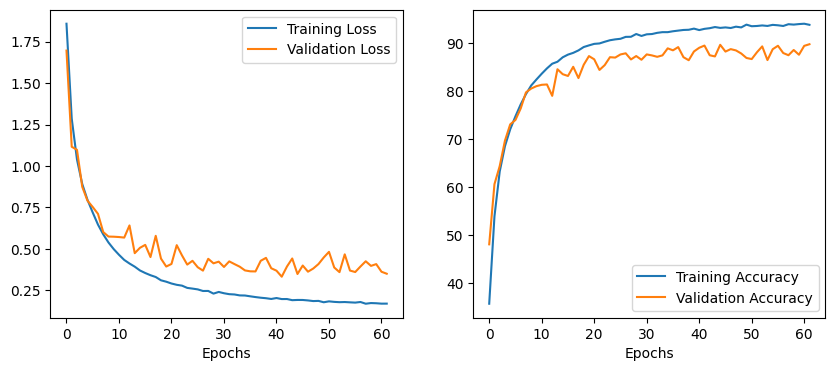

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

axs[0].plot(history["train_loss"], label='Training Loss')
axs[0].plot(history["val_loss"], label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()

axs[1].plot(history["train_acc"], label='Training Accuracy')
axs[1].plot(history["val_acc"], label='Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].legend()

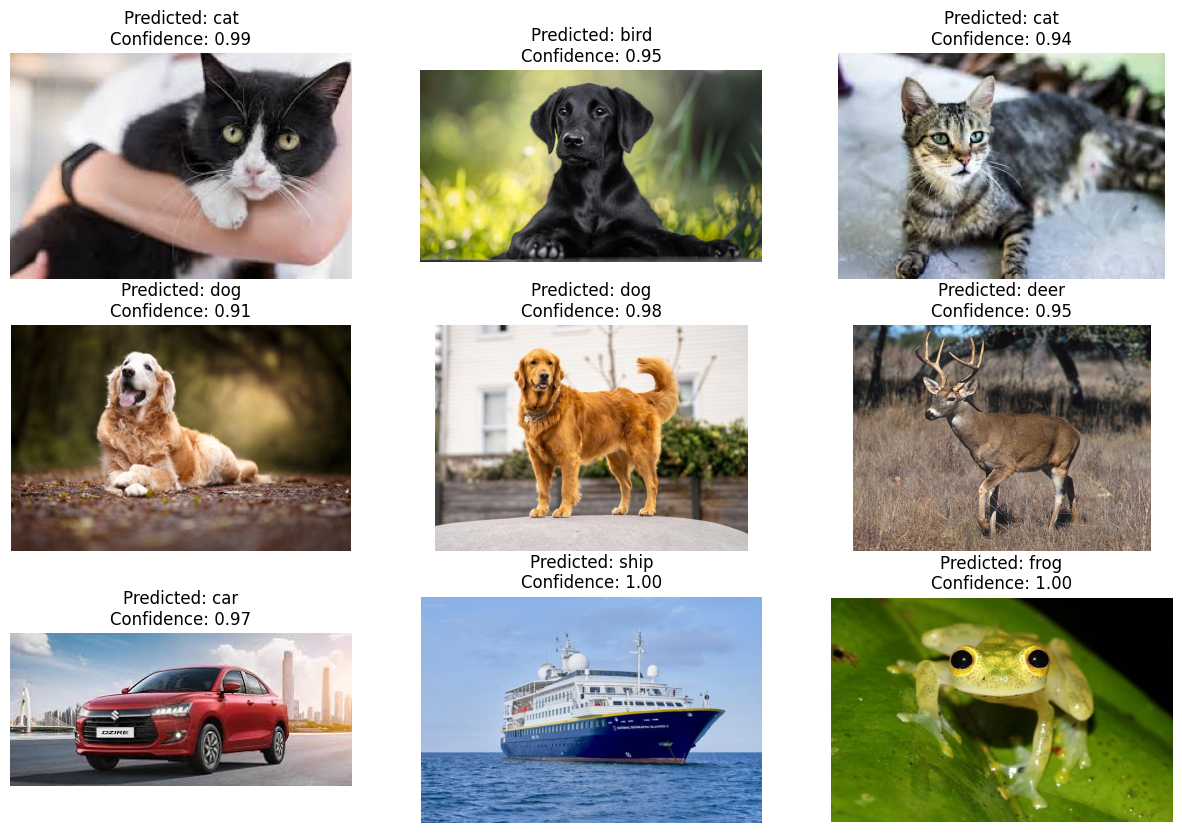

In [15]:
imgs = [
    r"C:\Users\joao_\Downloads\images (1).jpg",
    r"C:\Users\joao_\Downloads\88ff5600-d979-11ef-a5c8-1da73bd59591.jpg",
    r"C:\Users\joao_\Downloads\images.jpg",
    r"C:\Users\joao_\Downloads\iStock-1052880600.jpg",
    r"C:\Users\joao_\Downloads\Golden+Retrievers+dans+pet+care.jpeg",
    r"C:\Users\joao_\Downloads\640px-White-tailed_deer.jpg",
    r"C:\Users\joao_\Downloads\images (2).jpg",
    r"C:\Users\joao_\Downloads\new-day-2-islander-ii-jan23-1000x666.jpg.adapt.six-sixty-seven.jpg",
    r"C:\Users\joao_\Downloads\Glass_Frog.jpg"
]

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()

for idx, img_path in enumerate(imgs):
    img = Image.open(img_path)
    axs[idx].imshow(img)
    axs[idx].axis('off')
    
    pred_class_str, pred_class_n, probs = inference(dense_net_best_model, img)
    axs[idx].set_title(f'Predicted: {pred_class_str}\nConfidence: {probs[pred_class_n]:.2f}')